# Airbus Ship Detection

### Project`s imports

In [1]:
import os
import random

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.io import imshow

from misc.constants import CONST
from misc.data_processing import DataPreparation
from misc.mask_rle_processing import RLEMaskProcessor
%matplotlib inline

/home/nickolay/Python/airbus-ship-detection/venv/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
2024-02-28 16:47:09.624107: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 16:47:09.626700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-28 16:47:09.626709: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/home/nickolay/Python/airbus-ship-detection/data/train_v2


### Help functions

In [2]:
def get_random_img(directory: str) -> np.ndarray:
    random_image = random.sample(os.listdir(directory), 1)
    
    img = mpimg.imread(directory + "/" + random_image[0])
    plt.imshow(img)
    plt.axis("off")
    
    print(f"Image shape: {img.shape}")
    
    return img

In [3]:
def display_images_and_masks_side_by_side(images, masks):
    num_images = len(images)
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 6))
    for idx, (image, mask) in enumerate(zip(images, masks)):
        # Display the image
        axes[0, idx].imshow(image)
        axes[0, idx].set_title(f'Image {idx + 1}', fontsize=12)
        axes[0, idx].axis('off')

        # Display the corresponding mask
        axes[1, idx].imshow(mask.squeeze(), cmap='gray')
        axes[1, idx].set_title(f'Mask {idx + 1}', fontsize=12)
        axes[1, idx].axis('off')

    plt.tight_layout()
    plt.show()

### General knowledge about data

In [4]:
for dirpath, dirnames, filenames in os.walk(CONST.DATA_PATH):
  print(f"[{os.path.basename(dirpath)}] contains {len(dirnames)} directories and {len(filenames)} images/files.")

[data] contains 2 directories and 2 images/files.
[test_v2] contains 0 directories and 15606 images/files.


[train_v2] contains 0 directories and 192556 images/files.


### Dataset observation

In [5]:
df = pd.read_csv(CONST.CSV_PATH)
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


### Calculate unique amount of images in dataset

In [6]:
num_images = len(df['ImageId'].unique())
print(f"Dataset contains {num_images} unique images.")

Dataset contains 192556 unique images.


### Calculate amount of images related to specific class

In [7]:
num_ships = len(df[df['EncodedPixels'].notna()]) # remove NaN
num_non_ships = num_images - num_ships

print('Amount of images with ships:', num_ships)
print('Amount of images without ships:', num_non_ships)

Amount of images with ships: 81723
Amount of images without ships: 110833


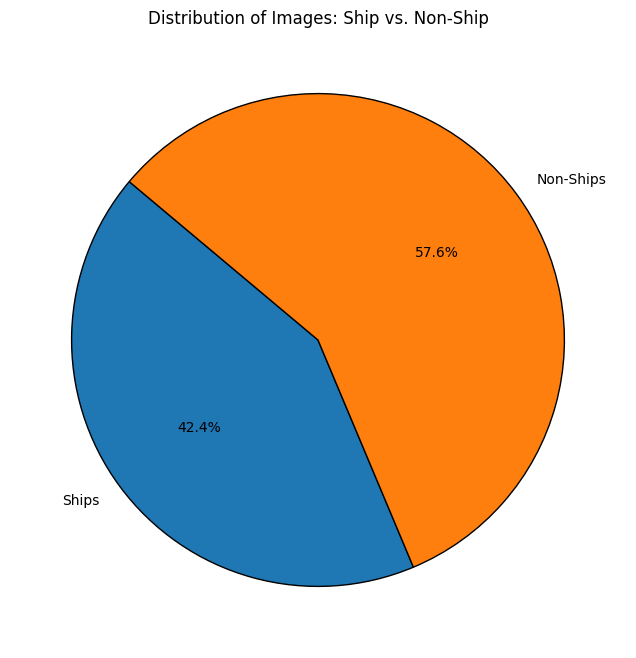

In [8]:
# Data
categories = ['Ships', 'Non-Ships']
counts = [num_ships, num_non_ships]

# Plot
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=140, wedgeprops=dict(edgecolor='black'))
plt.title('Distribution of Images: Ship vs. Non-Ship')
plt.show()

### Checking dataset`s image

Image shape: (768, 768, 3)


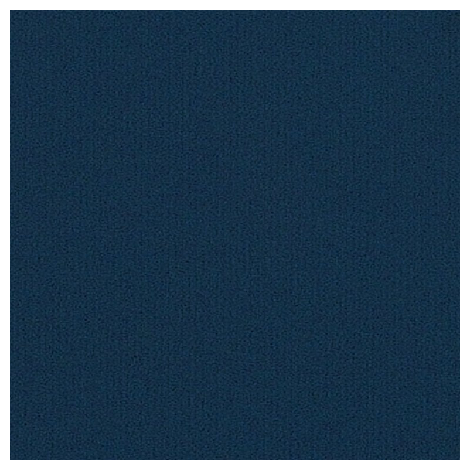

In [9]:
imshow(get_random_img(CONST.TEST_FOLDER))

## Display dataset distribution of ship number on an image

In [10]:
mask_amount = df["ImageId"].value_counts()
mask_amount

e6fd0c12e.jpg    15
2053a78bd.jpg    15
d3c47b3d3.jpg    15
4de149bd9.jpg    15
c8e722430.jpg    15
                 ..
591ab2331.jpg     1
591af2fb2.jpg     1
591afc23d.jpg     1
591b2dd30.jpg     1
ffffe97f3.jpg     1
Name: ImageId, Length: 192556, dtype: int64

In [11]:
# add new column which will display amount of ships on the image
ship_df = df.copy()
ship_df['ShipAmount'] = ship_df['EncodedPixels'].notnull().astype(int)
ship_df['EncodedPixels'] = ship_df['EncodedPixels'].replace(0, '')
ship_df.head()

,ImageId,EncodedPixels,ShipAmount
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1


In [12]:
ship_df = ship_df.groupby('ImageId').sum().reset_index()
ship_df.head()

,ImageId,ShipAmount
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0


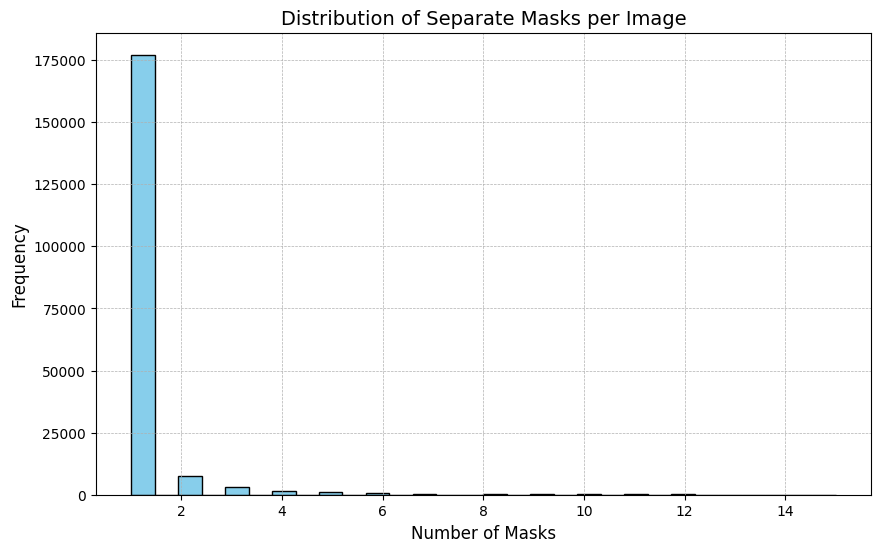

In [13]:
plt.figure(figsize=(10, 6))

plt.hist(mask_amount, bins=30, color='skyblue', edgecolor='black')


plt.title("Distribution of Separate Masks per Image", fontsize=14)
plt.xlabel("Number of Masks", fontsize=12)
plt.ylabel("Frequency", fontsize=12)


plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

### Preprocessing data

In [14]:
rle_with_zeros = RLEMaskProcessor.rle_encode(np.zeros((CONST.IMG_SIZE)))
assert rle_with_zeros == "", "Not equal"

We need to transform our data for easy model trainnig. As we can see `rle_encode()` our mask into empty string. Therefore we can transform our __NaN__ data into ""

In [15]:
df = df.fillna("")
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,
1,0001124c7.jpg,
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


__We can see that our samples are highly imbalanced. To fix it we should undersample the zero masks.__

In [16]:
data_processor = DataPreparation(CONST.CSV_PATH, CONST.BATCH_SIZE)
train_data, gen_data = data_processor.split_data()
train_ships, valid_ships = data_processor.get_full_samples() 

In previous cell of code I did undersampling and split data on a small batches. You can see how I was implemented that in `misc.data_processing`. 


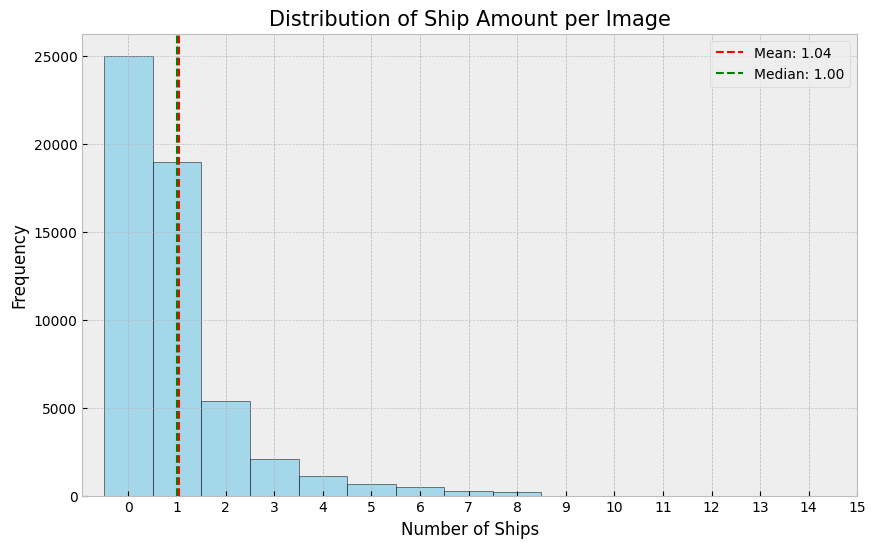

In [17]:
plt.style.use('bmh')

plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(
    train_ships['ShipAmount'], 
    bins=np.arange(10) - 0.5, 
    edgecolor='black', 
    color='skyblue',
    alpha=0.7
)

plt.title('Distribution of Ship Amount per Image', fontsize=15)
plt.xlabel('Number of Ships', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.xticks(ticks=np.arange(0, max(train_ships['ShipAmount'])+1), labels=np.arange(0, max(train_ships['ShipAmount'])+1))

plt.grid(axis='y', alpha=0.75)

mean_val = train_ships['ShipAmount'].mean()
median_val = train_ships['ShipAmount'].median()
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_val:.2f}')

plt.legend()

plt.show()


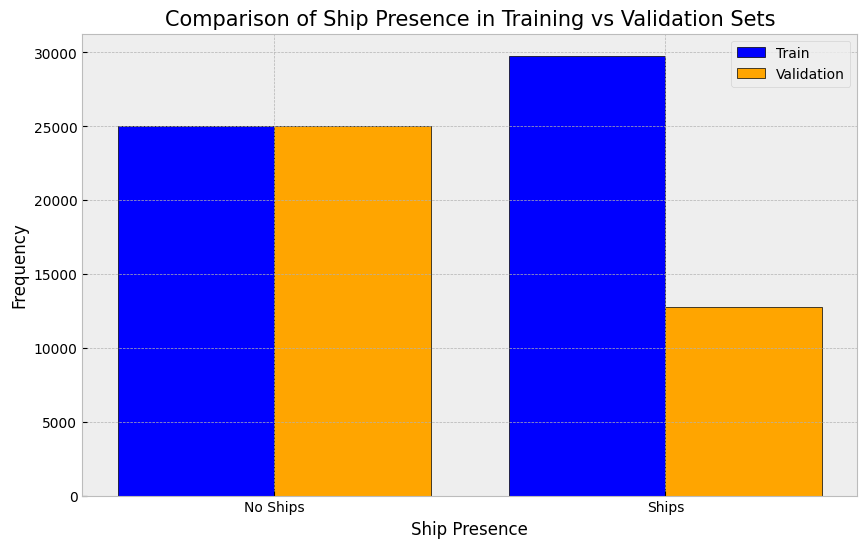

In [18]:
train_value_counts = (train_ships['ShipAmount'] > 0).astype(int).value_counts().sort_index()
valid_value_counts = (valid_ships['ShipAmount'] > 0).astype(int).value_counts().sort_index()

plt.figure(figsize=(10, 6))

train_bar = plt.bar(train_value_counts.index - 0.2, train_value_counts.values, width=0.4, label='Train', color='blue', edgecolor='black')
valid_bar = plt.bar(valid_value_counts.index + 0.2, valid_value_counts.values, width=0.4, label='Validation', color='orange', edgecolor='black')

plt.title('Comparison of Ship Presence in Training vs Validation Sets', fontsize=15)
plt.xlabel('Ship Presence', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Ships', 'Ships'])

plt.legend()

plt.show()


In result we have much nicer distribution than before. 

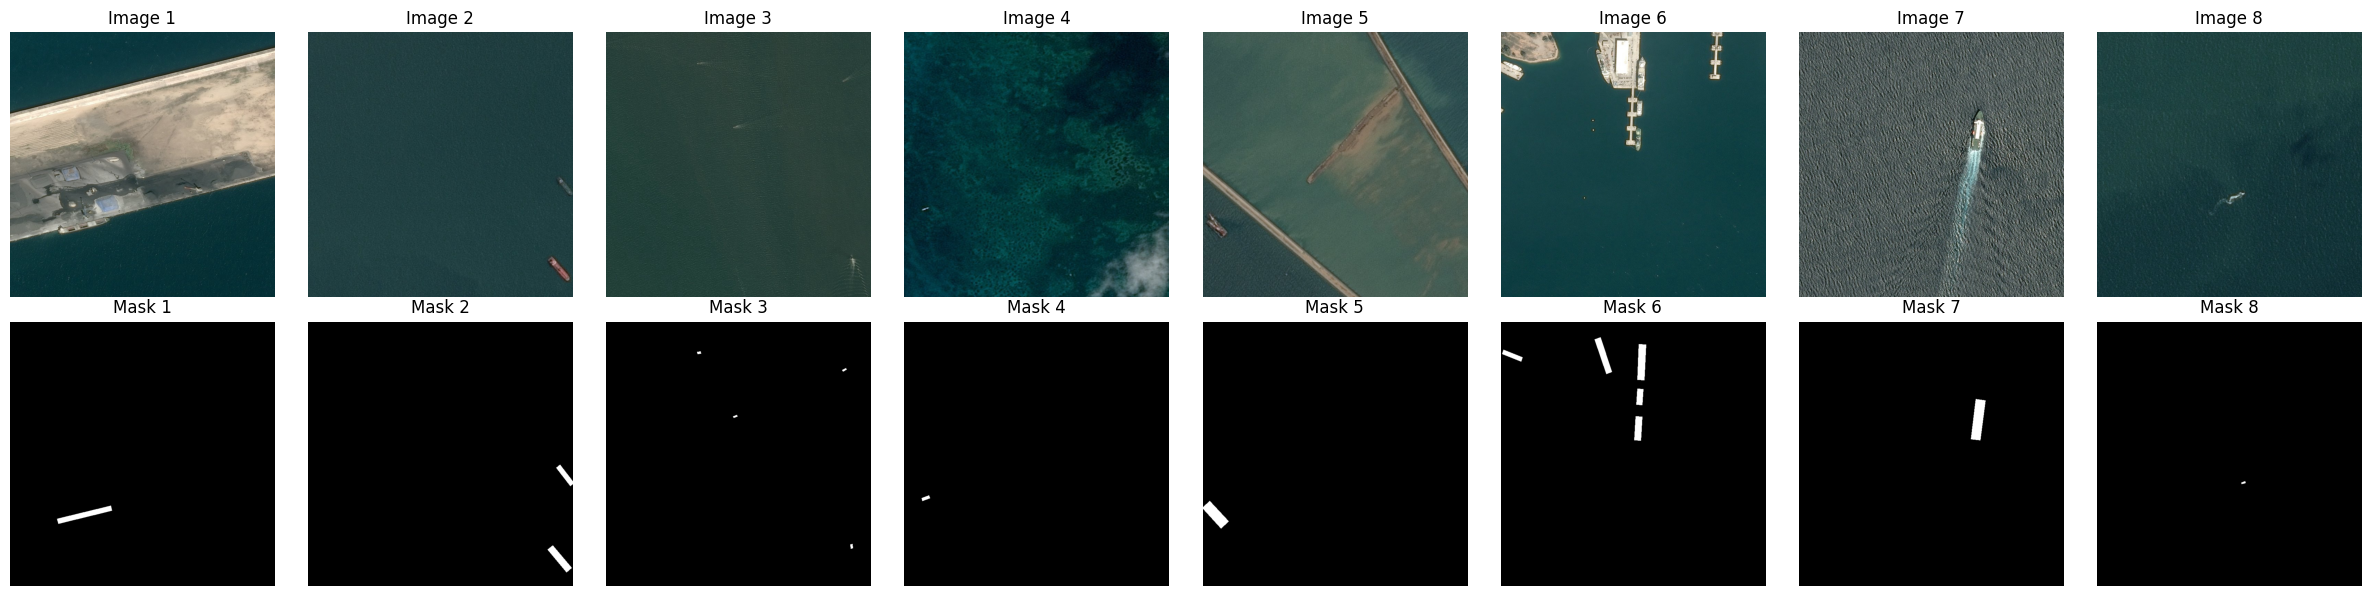

In [19]:
images, masks = train_data.__getitem__(0) 
display_images_and_masks_side_by_side(images, masks) # display images and their masks which are saved in segment loader

You can find code for training and evaluating model in `train.py` and `evaluate.py`